In [12]:
# Imports
import pandas as pd
import numpy as np
from IPython.display import display

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
import hdbscan
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

In [8]:
# Load data
df = pd.read_csv("./preproc_data/clean_text_all_subreddits_BoW.csv", low_memory=False)

# Print length
print(len(df.index))

# Check
df.head()

652146


,subreddit,date,author,id,num_comments,score,clean_text,unique_clean_text,post_length,word_count,...,final,till,extra,paper,business,touch,rate,ability,weed,label
0,ADHD,01/01/2019,DirtJunkie133,abd11x,13.0,1,recently diagnosed need talk others diagnosed ...,recently diagnosed need talk others well im ad...,3021,196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
1,ADHD,01/01/2019,Lin_the_pillow_artis,abd7q9,5.0,1,really annoyed family drunk friend family host...,really annoyed family drunk friend hosting new...,751,54,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,ADHD,01/01/2019,Fleetfeathers,abda0t,12.0,1,medication journey current disappointment wan...,medication journey current disappointment want...,1713,122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082604,0.0,0
3,ADHD,01/01/2019,UnleashedDebs,abdd13,4.0,1,wearable rem sleep detected gaming sleeping hy...,wearable rem sleep detected gaming sleeping hy...,988,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
4,ADHD,01/01/2019,liluglee,abdj4w,1.0,1,picking friend carpool nye party texted way dr...,picking friend carpool nye party texted way dr...,123,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0


In [8]:
# Remove rows with "Removed" in flair
df = df[~df["link_flair_text"].str.contains("removed", case=False, na=False)]

# Print length
print(len(df.index))

652146


In [12]:
# Read labeled flairs
lf = pd.read_csv("./preproc_data/flairs_mental_health.csv",
                 usecols=["Flair", "Depressed"], nrows=132)

lf

,Flair,Depressed
0,Questions/Advice/Support,0
1,Venting,0
2,Question,0
3,Need Support,1
4,Advice Needed,1
...,...,...
127,ADHD,1
128,Confused,1
129,OCD,1
130,Research,0


In [18]:
# List of depressed flairs
dep_flairs = list(lf[lf["Depressed"] == 1]["Flair"].values)

# Create label column
df["label"] = df["link_flair_text"].apply(lambda x: 1 if x in dep_flairs else 0)

# Check
df[df["label"] == 1].head()

,subreddit,date,author,id,num_comments,score,clean_text,unique_clean_text,post_length,word_count,...,final,till,extra,paper,business,touch,rate,ability,weed,label
0,ADHD,01/01/2019,DirtJunkie133,abd11x,13.0,1,recently diagnosed need talk others diagnosed ...,recently diagnosed need talk others well im ad...,3021,196,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
1,ADHD,01/01/2019,Lin_the_pillow_artis,abd7q9,5.0,1,really annoyed family drunk friend family host...,really annoyed family drunk friend hosting new...,751,54,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,ADHD,01/01/2019,Fleetfeathers,abda0t,12.0,1,medication journey current disappointment wan...,medication journey current disappointment want...,1713,122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082604,0.0,0
3,ADHD,01/01/2019,UnleashedDebs,abdd13,4.0,1,wearable rem sleep detected gaming sleeping hy...,wearable rem sleep detected gaming sleeping hy...,988,68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
4,ADHD,01/01/2019,liluglee,abdj4w,1.0,1,picking friend carpool nye party texted way dr...,picking friend carpool nye party texted way dr...,123,12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0


In [25]:
# Drop pronoun count (did it after stop word removal, and pronouns are stop words)
df = df.drop(columns=["norm_pronoun"])

# Save to csv
df.to_csv("./preproc_data/clean_text_all_subreddits_BoW.csv", index=False)

# Feature Selection

In [ ]:
# Load data
df = pd.read_csv("./preproc_data/clean_text_all_subreddits_BoW.csv", low_memory=False)

# Check
df.head()

# Print length
print(len(df.index))

In [ ]:
# Select all columns that are numeric
fs = df.select_dtypes(['number'])

# Compute correlation (Test for multicollinearity)
pc = fs.corr()

# Find all pairs with a correlation > 0.5 (tried 0.9 0.8, and 0.5 - no reduction made)
pc = pc.reset_index().melt(id_vars='index').query('value >= 0.5')

# Sort by value (correlation)
pc = pc.sort_values(by="value", ascending=False, ignore_index=True)

# Drop duplicates
pc = pc.drop_duplicates(subset=["variable"], ignore_index=True)

# Drop rows where value is 1, since this is index=variable case
pc = pc[pc["value"] < 1]

# Display
pc

In [9]:
# Count number of zeros in all columns of Dataframe
zeroes = (df.select_dtypes(['number']) == 0).sum()

zeroes = pd.DataFrame(zeroes, columns=["count"])

zeroes = zeroes.reset_index()

for i in range(len(zeroes.index)):
    print("The percentage of zeroes in column", zeroes["index"][i], "is:", zeroes["count"][i]/len(df.index))
    
# Find all columns with greater than 97% zeroes (95 is 249 rows, 97 is 410)
z = zeroes[zeroes["count"]/len(df.index) < 0.95]

display(z)

The percentage of zeroes in column num_comments is: 0.1845890337439776
The percentage of zeroes in column score is: 0.011790304625037952
The percentage of zeroes in column post_length is: 0.0
The percentage of zeroes in column word_count is: 0.0010979136573712022
The percentage of zeroes in column norm_noun is: 0.002551575874114079
The percentage of zeroes in column norm_verb is: 0.027852658760461613
The percentage of zeroes in column norm_adj is: 0.033156685772817746
The percentage of zeroes in column norm_adv is: 0.10627528191539931
The percentage of zeroes in column compound_sent is: 0.02978320805463807
The percentage of zeroes in column like is: 0.5021574923406722
The percentage of zeroes in column im is: 0.7026325393393504
The percentage of zeroes in column feel is: 0.580434442594143
The percentage of zeroes in column get is: 0.6093328794472403
The percentage of zeroes in column know is: 0.6164003152668267
The percentage of zeroes in column time is: 0.6294664078289217
The percenta

The percentage of zeroes in column chest is: 0.9753628788645488
The percentage of zeroes in column type is: 0.9675302769625207
The percentage of zeroes in column answer is: 0.9711536987116381
The percentage of zeroes in column outside is: 0.9681467033455698
The percentage of zeroes in column motivation is: 0.9755637541286767
The percentage of zeroes in column watch is: 0.974349302150132
The percentage of zeroes in column difficult is: 0.9687186611586976
The percentage of zeroes in column seen is: 0.9671913957917398
The percentage of zeroes in column anyway is: 0.9652547129017122
The percentage of zeroes in column explain is: 0.9703149294789817
The percentage of zeroes in column man is: 0.9732759228761657
The percentage of zeroes in column shes is: 0.9801838852036201
The percentage of zeroes in column knew is: 0.9644159436690557
The percentage of zeroes in column movie is: 0.9806945070582355
The percentage of zeroes in column severe is: 0.9715385818513033
The percentage of zeroes in col

The percentage of zeroes in column properly is: 0.9868848386710951
The percentage of zeroes in column overwhelming is: 0.9882756315303628
The percentage of zeroes in column headache is: 0.9908532751868446
The percentage of zeroes in column stimulant is: 0.9921965326782652
The percentage of zeroes in column improve is: 0.9886007121104783
The percentage of zeroes in column leg is: 0.9893183428250729
The percentage of zeroes in column seek is: 0.9878171452404829
The percentage of zeroes in column missed is: 0.9884443054162718
The percentage of zeroes in column language is: 0.9886497808772882
The percentage of zeroes in column uni is: 0.9902920511664566
The percentage of zeroes in column quiet is: 0.9878953485875862
The percentage of zeroes in column insane is: 0.988474973395528
The percentage of zeroes in column final is: 0.9890147298304367
The percentage of zeroes in column till is: 0.9879919527222432
The percentage of zeroes in column extra is: 0.9874828642665906
The percentage of zeroe

,index,count
0,num_comments,120379
1,score,7689
2,post_length,0
3,word_count,716
4,norm_noun,1664
...,...,...
273,saying,617639
301,came,618218
305,either,618862
309,least,619234


In [10]:
# Concatenate categorical and reduced numerical columns
df = pd.concat([df.select_dtypes(exclude=["number"]), df[z['index']]], axis=1)

# Display
df

,subreddit,date,author,id,clean_text,unique_clean_text,link_flair_text,num_comments,score,post_length,...,often,guess,stay,completely,leave,saying,came,either,least,label
0,ADHD,01/01/2019,DirtJunkie133,abd11x,recently diagnosed need talk others diagnosed ...,recently diagnosed need talk others well im ad...,NaN,13.0,1,3021,...,0.0,0.0,0.085928,0.0,0.0,0.0,0.000000,0.0,0.0,0
1,ADHD,01/01/2019,Lin_the_pillow_artis,abd7q9,really annoyed family drunk friend family host...,really annoyed family drunk friend hosting new...,NaN,5.0,1,751,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0
2,ADHD,01/01/2019,Fleetfeathers,abda0t,medication journey current disappointment wan...,medication journey current disappointment want...,NaN,12.0,1,1713,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0
3,ADHD,01/01/2019,UnleashedDebs,abdd13,wearable rem sleep detected gaming sleeping hy...,wearable rem sleep detected gaming sleeping hy...,NaN,4.0,1,988,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0
4,ADHD,01/01/2019,liluglee,abdj4w,picking friend carpool nye party texted way dr...,picking friend carpool nye party texted way dr...,NaN,1.0,1,123,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652141,sad,31/12/2020,RussianPower69,ko0jbp,sad one talk new year,sad one talk new year,Depression/Sadness,3.0,1,43,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1
652142,sad,31/12/2020,prettygirlolivia,ko0lec,worst new year eve ever depression hit bad las...,worst new year eve ever depression hit bad las...,NaN,8.0,1,318,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0
652143,sad,31/12/2020,DirtyLizard0032,ko0rtl,check sad song,check sad song,Depression/Sadness,2.0,1,22,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1
652144,sad,31/12/2020,Music-SunsetGirl490,ko0skv,zoom wedding tomorrow story let call groom bob...,zoom wedding tomorrow story let call groom bob...,Loneliness,3.0,1,486,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.069952,0.0,0.0,1


In [11]:
# Save to csv
df.to_csv("./preproc_data/clean_text_all_subreddits_BoW_reduced.csv", index=False)

In [4]:
# Print how many are ones
print(len(df[df["label"] == 1].index))
print(len(df[df["label"] == 0].index))
print(len(df[df["label"] == 1].index)/len(df.index))
print(len(df[df["label"] == 0].index)/len(df.index))

85439
566707
0.13101207398343315
0.8689879260165668


# Clustering

In [13]:
# Drop label column
df_copy = df.drop(columns=["label"])

# Select only numeric columns
df_copy = df_copy.select_dtypes(['number'])

# Scale data
df_copy[df_copy.columns] = StandardScaler().fit_transform(df_copy)

# Drop all rows with NaN
df_copy = df_copy.dropna()

# Disply
display(df_copy)

,num_comments,score,post_length,word_count,norm_noun,norm_verb,norm_adj,norm_adv,compound_sent,like,...,use,often,guess,stay,completely,leave,saying,came,either,least
0,0.053725,-0.037219,1.872750,2.286707,-0.000385,0.386145,-0.302998,0.029174,1.273688,0.732369,...,1.722016,-0.19956,-0.202832,3.640321,-0.208084,-0.189187,-0.200883,-0.198931,-0.202331,-0.198633
1,-0.019409,-0.037219,-0.155580,-0.125836,0.754612,-0.960765,-0.645358,-0.129778,-1.282187,-0.090004,...,-0.191031,-0.19956,-0.202832,-0.189439,-0.208084,-0.189187,-0.200883,-0.198931,-0.202331,-0.198633
2,0.044584,-0.037219,0.704003,1.029466,0.148139,-0.081685,0.122210,-0.308534,0.643440,0.326578,...,-0.191031,-0.19956,-0.202832,-0.189439,-0.208084,-0.189187,-0.200883,-0.198931,-0.202331,-0.198633
3,-0.028551,-0.037219,0.056189,0.112020,-0.197461,0.434426,0.135248,-0.203083,1.146846,-0.724359,...,-0.191031,-0.19956,-0.202832,-0.189439,-0.208084,-0.189187,-0.200883,-0.198931,-0.202331,-0.198633
4,-0.055976,-0.037219,-0.716721,-0.839405,1.525338,0.070463,-1.521700,-1.687508,1.102451,-0.724359,...,-0.191031,-0.19956,-0.202832,-0.189439,-0.208084,-0.189187,-0.200883,-0.198931,-0.202331,-0.198633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
652141,-0.037692,-0.037219,-0.788204,-0.958333,-0.170259,-3.023222,2.759855,-1.687508,-0.662509,-0.724359,...,-0.191031,-0.19956,-0.202832,-0.189439,-0.208084,-0.189187,-0.200883,-0.198931,-0.202331,-0.198633
652142,0.008016,-0.037219,-0.542481,-0.533590,-1.095130,-0.548274,0.957095,0.555624,-1.313765,0.554227,...,-0.191031,-0.19956,-0.202832,-0.189439,-0.208084,-0.189187,-0.200883,-0.198931,-0.202331,-0.198633
652143,-0.046834,-0.037219,-0.806968,-0.992313,2.296063,1.101692,-2.648425,-1.687508,-0.662509,-0.724359,...,-0.191031,-0.19956,-0.202832,-0.189439,-0.208084,-0.189187,-0.200883,-0.198931,-0.202331,-0.198633
652144,-0.037692,-0.037219,-0.392367,-0.346703,0.641823,-0.004993,-0.669786,-0.456521,0.297662,-0.126316,...,-0.191031,-0.19956,-0.202832,-0.189439,-0.208084,-0.189187,-0.200883,3.439805,-0.202331,-0.198633


In [14]:
# Initialize PCA
pca = PCA(2)
 
# Transform the data
df_pca = pca.fit_transform(df_copy)

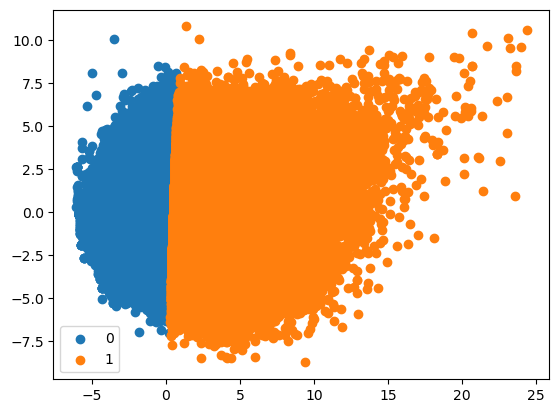

In [17]:
# Run K-Means
km_label = KMeans(n_clusters=2, random_state=0).fit_predict(df_pca.data)

# Get unique labels
kmean_labels = np.unique(km_label)

# Plot the results:
for i in kmean_labels:
    plt.scatter(df_pca[km_label == i , 0], df_pca[km_label == i, 1], label = i)
plt.legend()

plt.show()

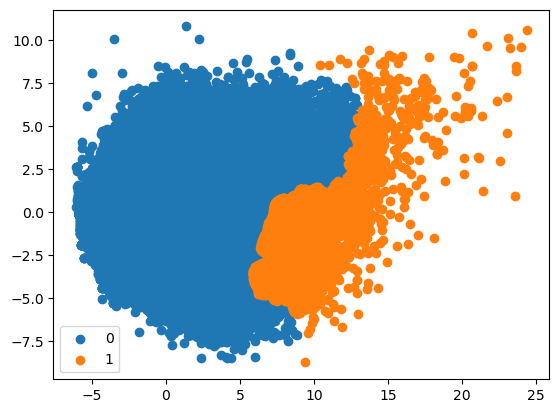

In [19]:
# Run BIRCH (Works with high dimensional data, had to use pca due to memory)
birch_label = Birch(n_clusters=2).fit_predict(df_pca.data)
birch_labels = np.unique(birch_label)

# Plot
for i in birch_labels:
    plt.scatter(df_pca[birch_label == i, 0], df_pca[birch_label == i, 1], label = i)
plt.legend()

plt.show()

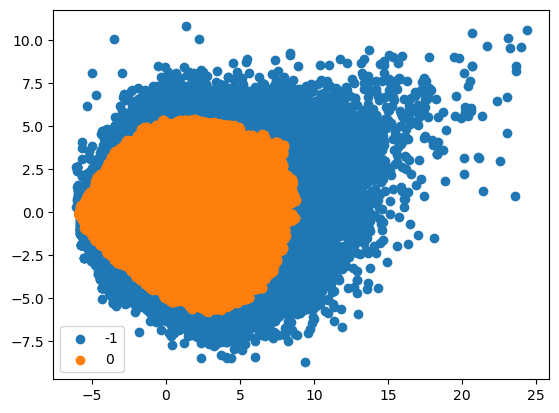

In [21]:
# Run HDBSCAN (Works with high dimensional data)
clusterer = hdbscan.HDBSCAN(min_cluster_size = 200, min_samples=1, allow_single_cluster=True)
clusters = clusterer.fit(df_pca.data)
hdbscan_label = clusterer.labels_

hdbscan_labels = np.unique(hdbscan_label)


for i in hdbscan_labels:
    plt.scatter(df_pca[hdbscan_label == i, 0], df_pca[hdbscan_label == i, 1], label = i)
plt.legend()

plt.show()

In [ ]:
# Run Spectral Clustering (Works with high dimensional data -- Doesn't work, ran out of memory)
# sc_label = SpectralClustering(n_clusters=2,
#                               assign_labels='discretize',
#                               random_state=0).fit_predict(df_pca.data)

# sc_labels = np.unique(sc_label)

# for i in sc_labels:
#     plt.scatter(df_pca[label == i , 0] , df_pca[label == i , 1] , label = i)
# plt.legend()

# plt.show()

In [22]:
# Reset index
df_copy = df_copy.reset_index()
df = df.reset_index()

# Add clustering labels to df_copy
df_copy["kmeans_label"] = list(km_label)
df_copy["birch_label"] = list(birch_label)
df_copy["hdbscan_label"] = list(hdbscan_label)
# df_copy["spectralClustering_label"] = list(sc_label)

# Convert kmeans_label to int
df_copy["kmeans_label"] = df_copy["kmeans_label"].astype(int)
df_copy["birch_label"] = df_copy["birch_label"].astype(int)
df_copy["hdbscan_label"] = df_copy["hdbscan_label"].astype(int)
# df_copy["spectralClustering_label"] = df_copy["spectralClustering_label"].astype(int)

# Select columns
df_copy = df_copy[["index", "kmeans_label", "birch_label", "hdbscan_label"]]

# Display
display(df_copy)

,index,kmeans_label,birch_label,hdbscan_label
0,0,1,0,0
1,1,0,0,0
2,2,1,0,0
3,3,0,0,0
4,4,0,0,0
...,...,...,...,...
651425,652141,0,0,0
651426,652142,1,0,0
651427,652143,0,0,0
651428,652144,0,0,0


In [23]:
# Merge with original data frame
df_merged = df_copy.merge(df)

# Check
df_merged.head()

,index,kmeans_label,birch_label,hdbscan_label,subreddit,date,author,id,clean_text,unique_clean_text,...,often,guess,stay,completely,leave,saying,came,either,least,label
0,0,1,0,0,ADHD,01/01/2019,DirtJunkie133,abd11x,recently diagnosed need talk others diagnosed ...,recently diagnosed need talk others well im ad...,...,0.0,0.0,0.085928,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0,0,0,ADHD,01/01/2019,Lin_the_pillow_artis,abd7q9,really annoyed family drunk friend family host...,really annoyed family drunk friend hosting new...,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,1,0,0,ADHD,01/01/2019,Fleetfeathers,abda0t,medication journey current disappointment wan...,medication journey current disappointment want...,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,0,0,0,ADHD,01/01/2019,UnleashedDebs,abdd13,wearable rem sleep detected gaming sleeping hy...,wearable rem sleep detected gaming sleeping hy...,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,0,0,0,ADHD,01/01/2019,liluglee,abdj4w,picking friend carpool nye party texted way dr...,picking friend carpool nye party texted way dr...,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0


In [24]:
# Select columns and display (can be easily merged back into original dataframe)
check = df_merged[["index", "subreddit", "clean_text", "label", "kmeans_label", "birch_label", "hdbscan_label"]]
display(check)

# Save to csv
check.to_csv("./preproc_data/clustered_BoW.csv", index=False)

,index,subreddit,clean_text,label,kmeans_label,birch_label,hdbscan_label
0,0,ADHD,recently diagnosed need talk others diagnosed ...,0,1,0,0
1,1,ADHD,really annoyed family drunk friend family host...,0,0,0,0
2,2,ADHD,medication journey current disappointment wan...,0,1,0,0
3,3,ADHD,wearable rem sleep detected gaming sleeping hy...,0,0,0,0
4,4,ADHD,picking friend carpool nye party texted way dr...,0,0,0,0
...,...,...,...,...,...,...,...
651425,652141,sad,sad one talk new year,1,0,0,0
651426,652142,sad,worst new year eve ever depression hit bad las...,0,1,0,0
651427,652143,sad,check sad song,1,0,0,0
651428,652144,sad,zoom wedding tomorrow story let call groom bob...,1,0,0,0


In [26]:
# Basic statistics
print("The number of 1s in label is", len(check[check["label"] == 1].index))
print("The number of 1s in kmeans_label is", len(check[check["kmeans_label"] == 1].index))
print("The number of 1s in birch_label is", len(check[check["birch_label"] == 1].index))
print("The number of 0s in hdbscan_label is", len(check[check["hdbscan_label"] == 0].index))
print("")
print("The number of 0s in label is", len(check[check["label"] == 0].index))
print("The number of 0s in kmeans_label is", len(check[check["kmeans_label"] == 0].index))
print("The number of 0s in birch_label is", len(check[check["birch_label"] == 0].index))
print("The number of -1s in hdbscan_label is", len(check[check["hdbscan_label"] == -1].index))

# Note: it's easier to find basic statistics filtering in Excel (i.e. for when birch and hdscan are the same)

The number of 1s in label is 85428
The number of 1s in kmeans_label is 253756
The number of 1s in birch_label is 6666
The number of 0s in hdbscan_label is 638629

The number of 0s in label is 566002
The number of 0s in kmeans_label is 397674
The number of 0s in birch_label is 644764
The number of -1s in hdbscan_label is 12801
